**LSTM**


d:\Users\tiago\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781 (6.96 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8862 - val_loss: 0.5382
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4299 - val_loss: 0.4086
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3256 - val_loss: 0.3181
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2573 - val_loss: 0.2411
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1996 - val_loss: 0.1730
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1565 - val_loss: 0.1346
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1294 - val_loss: 0.1094
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1099 - val_loss: 0.0924
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0958 - val_loss: 0.0812
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0853 - val_loss: 0.0738
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0772 - val_loss: 0.0686
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

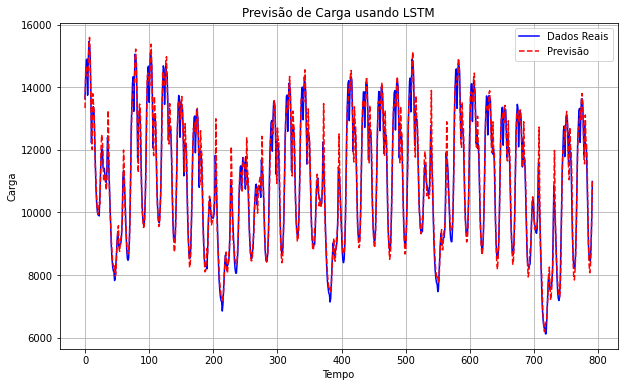

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# %% Gerar ou carregar dados
# Substitua por: dados = pd.read_excel('Carga2024.xlsx')
dados = pd.read_excel('CargaSul.xlsx')

# %% Extraindo dados da tabela Excel
carga = dados.iloc[:2000, 3].values  # Coluna 4 (índice 3)
#carga = np.sin(tempo) + 0.5 * np.random.normal(size=len(tempo))

# %% Normalizar os dados
scaler = StandardScaler()
carga_normalizada = scaler.fit_transform(carga.reshape(-1, 1)).flatten()

# Criar dados em formato de série temporal
def criar_dados(series, passos=20):
    X, Y = [], []
    for i in range(len(series) - passos):
        X.append(series[i:i + passos])
        Y.append(series[i + passos])
    return np.array(X), np.array(Y)

# Preparar os dados
passos_anteriores = 20
X, Y = criar_dados(carga_normalizada, passos_anteriores)

# Dividir os dados em treino e teste
split = int(0.6 * len(X))
X_train, Y_train = X[:split], Y[:split]
X_test, Y_test = X[split:], Y[split:]

# Ajustar o formato para LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# %% Criar o modelo LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(20, activation='tanh', input_shape=(passos_anteriores, 1)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()



# %% Treinar o modelo
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=16,
    shuffle=False,
    callbacks=[early_stopping],
)

# %% Fazer previsões
previsoes = model.predict(X_test)
previsoes = scaler.inverse_transform(previsoes)
Y_test_real = scaler.inverse_transform(Y_test.reshape(-1, 1))

# %% Avaliar o modelo
MAPE = np.mean(np.abs((previsoes - Y_test_real) / Y_test_real)) * 100
MAE = np.mean(np.abs(previsoes - Y_test_real))
RMSE = np.sqrt(np.mean((previsoes - Y_test_real) ** 2))

print(f'Erro Percentual Absoluto Médio (MAPE): {MAPE:.4f}%')
print(f'Erro Absoluto Médio (MAE): {MAE:.4f}')
print(f'Raiz do Erro Quadrático Médio (RMSE): {RMSE:.4f}')

# %% Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(Y_test_real, label='Dados Reais', color='blue')
plt.plot(previsoes, label='Previsão', color='red', linestyle='--')
plt.legend()
plt.xlabel('Tempo')
plt.ylabel('Carga')
plt.title('Previsão de Carga usando LSTM')
plt.grid(True)
plt.show()


In [ ]:
def previsao_carga():
    st.title("Previsão de Carga")
    
    tipo_modelo = st.sidebar.selectbox("Escolha o modelo", ["Modelo Linear", "Rede Neural"])
    horizonte_previsao = st.sidebar.number_input("Horizonte de Previsão (em dias)", value=7)
    
    # Upload do arquivo de entrada
    uploaded_file = st.file_uploader("Carregue o arquivo de dados da carga (Excel)", type="xlsx")
    if uploaded_file is None:
        st.warning("Por favor, carregue um arquivo Excel para continuar.")
        return
    fig = go.Figure()

    # Adicionar linha dos dados reais
    fig.add_trace(go.Scatter(
        y=Y_test_real.flatten(),
        mode='lines',
        name='Dados Reais',
        line=dict(color='blue')
    ))

    # Adicionar linha das previsões
    fig.add_trace(go.Scatter(
        y=previsoes.flatten(),
        mode='lines',
        name='Previsão',
        line=dict(color='red', dash='dash')
    ))

    # Configurar layout do gráfico
    fig.update_layout(
        title='Previsão de Carga usando LSTM',
        xaxis_title='Tempo',
        yaxis_title='Carga',
        legend=dict(x=0, y=1),
        template='plotly_white',
    )

    # Exibir no Streamlit
    st.title("Visualização de Previsão de Carga")
    st.plotly_chart(fig)
    save_and_create_button(fig,1)

# Interface principal
if __name__ == "__main__":
    st.sidebar.title("Escolha a funcionalidade")
    opcao = st.sidebar.radio("Selecione:", ["Despacho Econômico", "Previsão de Carga"])

    if opcao == "Despacho Econômico":
        x=1

    elif opcao == "Previsão de Carga":
        previsao_carga()

def save_and_create_button(fig, graph_num):
        # Salvando as imagens nos diferentes formatos
        output_file_jpeg = f"grafico_{graph_num}_high_quality.jpg"
        output_file_png = f"grafico_{graph_num}_high_quality.png"
        output_file_svg = f"grafico_{graph_num}_high_quality.svg"

        # Salvando a imagem em diferentes formatos
        fig.write_image(output_file_jpeg, format='jpeg', scale=3)
        fig.write_image(output_file_png, format='png', scale=3)
        fig.write_image(output_file_svg, format='svg', scale=3)

        # Selecionando o formato para download
        format_option = st.selectbox(
            f"Escolha o formato para baixar o gráfico {graph_num}",
            ['Selecione', 'JPEG', 'PNG', 'SVG']
        )

        # Criando o botão de download baseado na escolha do formato
        if format_option == 'JPEG':
            with open(output_file_jpeg, "rb") as file:
                st.download_button(
                    label=f"Baixar Gráfico {graph_num} em JPEG",
                    data=file,
                    file_name=f"grafico_{graph_num}_high_quality.jpg",
                    mime="image/jpeg"
                )
        elif format_option == 'PNG':
            with open(output_file_png, "rb") as file:
                st.download_button(
                    label=f"Baixar Gráfico {graph_num} em PNG",
                    data=file,
                    file_name=f"grafico_{graph_num}_high_quality.png",
                    mime="image/png"
                )
        elif format_option == 'SVG':
            with open(output_file_svg, "rb") as file:
                st.download_button(
                    label=f"Baixar Gráfico {graph_num} em SVG",
                    data=file,
                    file_name=f"grafico_{graph_num}_high_quality.svg",
                    mime="image/svg+xml"
                )

In [14]:

import plotly.graph_objects as go

# Criar figura
fig = go.Figure()

# Adicionar linha dos dados reais
fig.add_trace(go.Scatter(
    y=Y_test_real.flatten(),
    mode='lines',
    name='Dados Reais',
    line=dict(color='blue')
))

# Adicionar linha das previsões
fig.add_trace(go.Scatter(
    y=previsoes.flatten(),
    mode='lines',
    name='Previsão',
    line=dict(color='red', dash='dash')
))

# Configurar layout do gráfico
fig.update_layout(
    title='Previsão de Carga usando LSTM',
    xaxis_title='Tempo',
    yaxis_title='Carga',
    legend=dict(x=0, y=1),
    template='plotly_white',
)

# Mostrar gráfico interativo
fig.show()



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "d:\Users\tiago\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "d:\Users\tiago\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "d:\Users\tiago\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "d:\Users\tiago\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "d:\Users\tiago\anaconda3\lib\site-pack

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "d:\Users\tiago\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "d:\Users\tiago\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "d:\Users\tiago\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "d:\Users\tiago\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "d:\Users\tiago\anaconda3\lib\site-pack

AttributeError: _ARRAY_API not found

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4734

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 1.4684 - val_loss: 1.2699 - learning_rate: 1.0000e-04
Epoch 2/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2889

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.2891 - val_loss: 1.1548 - learning_rate: 1.0000e-04
Epoch 3/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2664

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.2598 - val_loss: 1.0412 - learning_rate: 1.0000e-04
Epoch 4/250
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0456

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0447 - val_loss: 0.9298 - learning_rate: 1.0000e-04
Epoch 5/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9132

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9130 - val_loss: 0.8176 - learning_rate: 1.0000e-04
Epoch 6/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8543

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8512 - val_loss: 0.7384 - learning_rate: 1.0000e-04
Epoch 7/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7371

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7368 - val_loss: 0.6831 - learning_rate: 1.0000e-04
Epoch 8/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6673

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6674 - val_loss: 0.6385 - learning_rate: 1.0000e-04
Epoch 9/250
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6292

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6267 - val_loss: 0.5721 - learning_rate: 1.0000e-04
Epoch 10/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5548

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5538 - val_loss: 0.4889 - learning_rate: 1.0000e-04
Epoch 11/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4786 - val_loss: 0.5147 - learning_rate: 1.0000e-04
Epoch 12/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4350

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.4347 - val_loss: 0.4628 - learning_rate: 1.0000e-04
Epoch 13/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4338

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4334 - val_loss: 0.4140 - learning_rate: 1.0000e-04
Epoch 14/250
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3879

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3882 - val_loss: 0.3846 - learning_rate: 1.0000e-04
Epoch 15/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3745

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3745 - val_loss: 0.3833 - learning_rate: 1.0000e-04
Epoch 16/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3748

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.3738 - val_loss: 0.3296 - learning_rate: 1.0000e-04
Epoch 17/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3396

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3393 - val_loss: 0.3101 - learning_rate: 1.0000e-04
Epoch 18/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3210

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3209 - val_loss: 0.2916 - learning_rate: 1.0000e-04
Epoch 19/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3102 - val_loss: 0.3008 - learning_rate: 1.0000e-04
Epoch 20/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3079

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3070 - val_loss: 0.2845 - learning_rate: 1.0000e-04
Epoch 21/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2890

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2889 - val_loss: 0.2732 - learning_rate: 1.0000e-04
Epoch 22/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2890

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2890 - val_loss: 0.2661 - learning_rate: 1.0000e-04
Epoch 23/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2754 - val_loss: 0.2772 - learning_rate: 1.0000e-04
Epoch 24/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2829

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2828 - val_loss: 0.2581 - learning_rate: 1.0000e-04
Epoch 25/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2628

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2630 - val_loss: 0.2525 - learning_rate: 1.0000e-04
Epoch 26/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2636 - val_loss: 0.2710 - learning_rate: 1.0000e-04
Epoch 27/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2755

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2746 - val_loss: 0.2479 - learning_rate: 1.0000e-04
Epoch 28/250
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2532

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2535 - val_loss: 0.2426 - learning_rate: 1.0000e-04
Epoch 29/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2488

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.2488 - val_loss: 0.2383 - learning_rate: 1.0000e-04
Epoch 30/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2536 - val_loss: 0.2466 - learning_rate: 1.0000e-04
Epoch 31/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2547

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2546 - val_loss: 0.2378 - learning_rate: 1.0000e-04
Epoch 32/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2416 - val_loss: 0.2496 - learning_rate: 1.0000e-04
Epoch 33/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2449

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2447 - val_loss: 0.2302 - learning_rate: 1.0000e-04
Epoch 34/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2358

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2358 - val_loss: 0.2261 - learning_rate: 1.0000e-04
Epoch 35/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2320

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2321 - val_loss: 0.2260 - learning_rate: 1.0000e-04
Epoch 36/250
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2328

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2324 - val_loss: 0.2232 - learning_rate: 1.0000e-04
Epoch 37/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2293 - val_loss: 0.2295 - learning_rate: 1.0000e-04
Epoch 38/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2303 - val_loss: 0.2451 - learning_rate: 1.0000e-04
Epoch 39/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2280

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2280 - val_loss: 0.2180 - learning_rate: 1.0000e-04
Epoch 40/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2225 - val_loss: 0.2192 - learning_rate: 1.0000e-04
Epoch 41/250
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2194

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2201 - val_loss: 0.2134 - learning_rate: 1.0000e-04
Epoch 42/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2216 - val_loss: 0.2177 - learning_rate: 1.0000e-04
Epoch 43/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2276

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2273 - val_loss: 0.2121 - learning_rate: 1.0000e-04
Epoch 44/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2238

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2234 - val_loss: 0.2082 - learning_rate: 1.0000e-04
Epoch 45/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2256 - val_loss: 0.2088 - learning_rate: 1.0000e-04
Epoch 46/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2116 - val_loss: 0.2095 - learning_rate: 1.0000e-04
Epoch 47/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2089

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2095 - val_loss: 0.2057 - learning_rate: 1.0000e-04
Epoch 48/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2159 - val_loss: 0.2074 - learning_rate: 1.0000e-04
Epoch 49/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2052

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2053 - val_loss: 0.2028 - learning_rate: 1.0000e-04
Epoch 50/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2086 - val_loss: 0.2037 - learning_rate: 1.0000e-04
Epoch 51/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2047

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2048 - val_loss: 0.2000 - learning_rate: 1.0000e-04
Epoch 52/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2087 - val_loss: 0.2013 - learning_rate: 1.0000e-04
Epoch 53/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2033 - val_loss: 0.2003 - learning_rate: 1.0000e-04
Epoch 54/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2059 - val_loss: 0.2005 - learning_rate: 1.0000e-04
Epoch 55/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2020

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2021 - val_loss: 0.2000 - learning_rate: 1.0000e-04
Epoch 56/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1992

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1993 - val_loss: 0.1982 - learning_rate: 1.0000e-04
Epoch 57/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1962 - val_loss: 0.1987 - learning_rate: 1.0000e-04
Epoch 58/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2110

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2105 - val_loss: 0.1972 - learning_rate: 1.0000e-04
Epoch 59/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2036 - val_loss: 0.1995 - learning_rate: 1.0000e-04
Epoch 60/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2047

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2046 - val_loss: 0.1925 - learning_rate: 1.0000e-04
Epoch 61/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2033 - val_loss: 0.1925 - learning_rate: 1.0000e-04
Epoch 62/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1976 - val_loss: 0.2042 - learning_rate: 1.0000e-04
Epoch 63/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2016 - val_loss: 0.1931 - learning_rate: 1.0000e-04
Epoch 64/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1953 - val_loss: 0.1938 - learning_rate: 1.0000e-04
Epoch 65/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1994
Epoch 65: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1995 - val_loss: 0.2039 - learning_rate: 1.0000e-04
Epoch 66/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1949

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1949 - val_loss: 0.1902 - learning_rate: 5.0000e-05
Epoch 67/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1936

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1936 - val_loss: 0.1890 - learning_rate: 5.0000e-05
Epoch 68/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1944

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1944 - val_loss: 0.1881 - learning_rate: 5.0000e-05
Epoch 69/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1927 - val_loss: 0.1901 - learning_rate: 5.0000e-05
Epoch 70/250
39/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1877

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1882 - val_loss: 0.1876 - learning_rate: 5.0000e-05
Epoch 71/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1941

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1939 - val_loss: 0.1869 - learning_rate: 5.0000e-05
Epoch 72/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1878

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1880 - val_loss: 0.1868 - learning_rate: 5.0000e-05
Epoch 73/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1873 - val_loss: 0.1902 - learning_rate: 5.0000e-05
Epoch 74/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1946 - val_loss: 0.1935 - learning_rate: 5.0000e-05
Epoch 75/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1858

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1861 - val_loss: 0.1859 - learning_rate: 5.0000e-05
Epoch 76/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1902

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1902 - val_loss: 0.1852 - learning_rate: 5.0000e-05
Epoch 77/250
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1930

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1927 - val_loss: 0.1846 - learning_rate: 5.0000e-05
Epoch 78/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1945 - val_loss: 0.1852 - learning_rate: 5.0000e-05
Epoch 79/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1854 - val_loss: 0.1851 - learning_rate: 5.0000e-05
Epoch 80/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1844 - val_loss: 0.1883 - learning_rate: 5.0000e-05
Epoch 81/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1825

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1826 - val_loss: 0.1842 - learning_rate: 5.0000e-05
Epoch 82/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1898 - val_loss: 0.1905 - learning_rate: 5.0000e-05
Epoch 83/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1876

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1877 - val_loss: 0.1838 - learning_rate: 5.0000e-05
Epoch 84/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1860

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1860 - val_loss: 0.1834 - learning_rate: 5.0000e-05
Epoch 85/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1831 - val_loss: 0.1896 - learning_rate: 5.0000e-05
Epoch 86/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1939

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1938 - val_loss: 0.1821 - learning_rate: 5.0000e-05
Epoch 87/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1814 - val_loss: 0.1822 - learning_rate: 5.0000e-05
Epoch 88/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1840 - val_loss: 0.1851 - learning_rate: 5.0000e-05
Epoch 89/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1871

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1869 - val_loss: 0.1819 - learning_rate: 5.0000e-05
Epoch 90/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1856 - val_loss: 0.1891 - learning_rate: 5.0000e-05
Epoch 91/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1883

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1880 - val_loss: 0.1811 - learning_rate: 5.0000e-05
Epoch 92/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1782 - val_loss: 0.2006 - learning_rate: 5.0000e-05
Epoch 93/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1890

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1890 - val_loss: 0.1804 - learning_rate: 5.0000e-05
Epoch 94/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1823 - val_loss: 0.1830 - learning_rate: 5.0000e-05
Epoch 95/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1810 - val_loss: 0.1836 - learning_rate: 5.0000e-05
Epoch 96/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1833

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1832 - val_loss: 0.1799 - learning_rate: 5.0000e-05
Epoch 97/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1843

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1841 - val_loss: 0.1793 - learning_rate: 5.0000e-05
Epoch 98/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1818 - val_loss: 0.1794 - learning_rate: 5.0000e-05
Epoch 99/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1807 - val_loss: 0.1806 - learning_rate: 5.0000e-05
Epoch 100/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1812 - val_loss: 0.1795 - learning_rate: 5.0000e-05
Epoch 101/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1881

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1874 - val_loss: 0.1778 - learning_rate: 5.0000e-05
Epoch 102/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1793 - val_loss: 0.1824 - learning_rate: 5.0000e-05
Epoch 103/250
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1790

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1791 - val_loss: 0.1774 - learning_rate: 5.0000e-05
Epoch 104/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1810 - val_loss: 0.1806 - learning_rate: 5.0000e-05
Epoch 105/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1745

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1746 - val_loss: 0.1767 - learning_rate: 5.0000e-05
Epoch 106/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1813 - val_loss: 0.1863 - learning_rate: 5.0000e-05
Epoch 107/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1839 - val_loss: 0.1784 - learning_rate: 5.0000e-05
Epoch 108/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1872 - val_loss: 0.1769 - learning_rate: 5.0000e-05
Epoch 109/250
39/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1780

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1779 - val_loss: 0.1758 - learning_rate: 5.0000e-05
Epoch 110/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1717 - val_loss: 0.1766 - learning_rate: 5.0000e-05
Epoch 111/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1782 - val_loss: 0.1822 - learning_rate: 5.0000e-05
Epoch 112/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1823 - val_loss: 0.1780 - learning_rate: 5.0000e-05
Epoch 113/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1725 - val_loss: 0.1773 - learning_rate: 5.0000e-05
Epoch 114/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1768
Epoch 114: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1768 - val_loss: 0.1859 - learning_rate: 5.0000e-05
Epoch 115/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1760

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1761 - val_loss: 0.1749 - learning_rate: 2.5000e-05
Epoch 116/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1796

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1792 - val_loss: 0.1740 - learning_rate: 2.5000e-05
Epoch 117/250
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1751

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1751 - val_loss: 0.1739 - learning_rate: 2.5000e-05
Epoch 118/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1751 - val_loss: 0.1740 - learning_rate: 2.5000e-05
Epoch 119/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1742 - val_loss: 0.1743 - learning_rate: 2.5000e-05
Epoch 120/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1721 - val_loss: 0.1764 - learning_rate: 2.5000e-05
Epoch 121/250
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1754

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1753 - val_loss: 0.1731 - learning_rate: 2.5000e-05
Epoch 122/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1796 - val_loss: 0.1734 - learning_rate: 2.5000e-05
Epoch 123/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1784 - val_loss: 0.1738 - learning_rate: 2.5000e-05
Epoch 124/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1797

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1796 - val_loss: 0.1727 - learning_rate: 2.5000e-05
Epoch 125/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1759 - val_loss: 0.1730 - learning_rate: 2.5000e-05
Epoch 126/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1764 - val_loss: 0.1729 - learning_rate: 2.5000e-05
Epoch 127/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1792 - val_loss: 0.1729 - learning_rate: 2.5000e-05
Epoch 128/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1785 - val_loss: 0.1739 - learning_rate: 2.5000e-05
Epoch 129/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1767
Epoch 129: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1767 - val_loss: 0.1750 - learning_rate: 2.5000e-05
Epoch 130/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1732

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1732 - val_loss: 0.1722 - learning_rate: 1.2500e-05
Epoch 131/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1696

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1698 - val_loss: 0.1721 - learning_rate: 1.2500e-05
Epoch 132/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1742 - val_loss: 0.1729 - learning_rate: 1.2500e-05
Epoch 133/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1702 - val_loss: 0.1724 - learning_rate: 1.2500e-05
Epoch 134/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1740 - val_loss: 0.1725 - learning_rate: 1.2500e-05
Epoch 135/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1709

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1710 - val_loss: 0.1720 - learning_rate: 1.2500e-05
Epoch 136/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1759

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1758 - val_loss: 0.1718 - learning_rate: 1.2500e-05
Epoch 137/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1676 - val_loss: 0.1739 - learning_rate: 1.2500e-05
Epoch 138/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1753 - val_loss: 0.1734 - learning_rate: 1.2500e-05
Epoch 139/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1700 - val_loss: 0.1749 - learning_rate: 1.2500e-05
Epoch 140/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1724

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1724 - val_loss: 0.1718 - learning_rate: 1.2500e-05
Epoch 141/250
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1746

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1745 - val_loss: 0.1716 - learning_rate: 1.2500e-05
Epoch 142/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1751 - val_loss: 0.1727 - learning_rate: 1.2500e-05
Epoch 143/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1749 - val_loss: 0.1723 - learning_rate: 1.2500e-05
Epoch 144/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1706

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1707 - val_loss: 0.1709 - learning_rate: 1.2500e-05
Epoch 145/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1683 - val_loss: 0.1730 - learning_rate: 1.2500e-05
Epoch 146/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1677 - val_loss: 0.1710 - learning_rate: 1.2500e-05
Epoch 147/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1733 - val_loss: 0.1727 - learning_rate: 1.2500e-05
Epoch 148/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1729

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1729 - val_loss: 0.1708 - learning_rate: 1.2500e-05
Epoch 149/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1740 - val_loss: 0.1708 - learning_rate: 1.2500e-05
Epoch 150/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1747 - val_loss: 0.1710 - learning_rate: 1.2500e-05
Epoch 151/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1681 - val_loss: 0.1716 - learning_rate: 1.2500e-05
Epoch 152/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1752 - val_loss: 0.1708 - learning_rate: 1.2500e-05
Epoch 153/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1741

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1739 - val_loss: 0.1705 - learning_rate: 1.2500e-05
Epoch 154/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1718

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1717 - val_loss: 0.1705 - learning_rate: 1.2500e-05
Epoch 155/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1735 - val_loss: 0.1708 - learning_rate: 1.2500e-05
Epoch 156/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1719 - val_loss: 0.1711 - learning_rate: 1.2500e-05
Epoch 157/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1757 - val_loss: 0.1716 - learning_rate: 1.2500e-05
Epoch 158/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1704

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1704 - val_loss: 0.1702 - learning_rate: 1.2500e-05
Epoch 159/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1722 - val_loss: 0.1720 - learning_rate: 1.2500e-05
Epoch 160/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1713 - val_loss: 0.1708 - learning_rate: 1.2500e-05
Epoch 161/250
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1704

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1704 - val_loss: 0.1700 - learning_rate: 1.2500e-05
Epoch 162/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1706

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1706 - val_loss: 0.1700 - learning_rate: 1.2500e-05
Epoch 163/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1673 - val_loss: 0.1721 - learning_rate: 1.2500e-05
Epoch 164/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1680

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1681 - val_loss: 0.1697 - learning_rate: 1.2500e-05
Epoch 165/250
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1793

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1786 - val_loss: 0.1695 - learning_rate: 1.2500e-05
Epoch 166/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1695 - val_loss: 0.1701 - learning_rate: 1.2500e-05
Epoch 167/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1697 - val_loss: 0.1700 - learning_rate: 1.2500e-05
Epoch 168/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1686 - val_loss: 0.1700 - learning_rate: 1.2500e-05
Epoch 169/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1670 - val_loss: 0.1705 - learning_rate: 1.2500e-05
Epoch 170/250
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1710


Epoch 170: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1711 - val_loss: 0.1694 - learning_rate: 1.2500e-05
Epoch 171/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1696 - val_loss: 0.1699 - learning_rate: 6.2500e-06
Epoch 172/250
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1694

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1695 - val_loss: 0.1691 - learning_rate: 6.2500e-06
Epoch 173/250
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1660

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1665 - val_loss: 0.1691 - learning_rate: 6.2500e-06
Epoch 174/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1672 - val_loss: 0.1703 - learning_rate: 6.2500e-06
Epoch 175/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1685 - val_loss: 0.1724 - learning_rate: 6.2500e-06
Epoch 176/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1684 - val_loss: 0.1691 - learning_rate: 6.2500e-06
Epoch 177/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1680
Epoch 177: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1680 - val_loss: 0.1703 - learning_rate: 6.2500e-06
Epoch 178/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1697 - val_loss: 0.1700 - learning_rate: 3.1250e-06
Epoch 179/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1662 - val_loss: 0.1700 - learning_rate: 3.1250e-06
Epoch 180/250
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1748

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1745 - val_loss: 0.1690 - learning_rate: 3.1250e-06
Epoch 181/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1708 - val_loss: 0.1694 - learning_rate: 3.1250e-06
Epoch 182/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1679 - val_loss: 0.1697 - learning_rate: 3.1250e-06
Epoch 183/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1630 - val_loss: 0.1697 - learning_rate: 3.1250e-06
Epoch 184/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1678 - val_loss: 0.1691 - learning_rate: 3.1250e-06
Epoch 185/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1691
Epoch 185: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1691 - val_loss: 0.1694 - learning_rate: 3.1250e-06
Epoch 186/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1665 - val_loss: 0.1694 - learning_rate: 1.5625e-06
Epoch 187/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1612 -

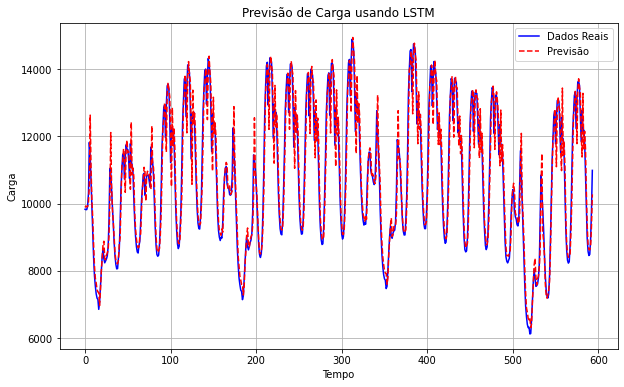

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# %% Carregar dados
dados = pd.read_excel('CargaSul.xlsx')

# %% Extraindo dados da tabela Excel
carga = dados.iloc[:2000, 3].values  # Coluna 4 (índice 3)

# %% Verificar por NaN ou valores inconsistentes
assert not np.any(np.isnan(carga)), "Os dados contêm valores NaN"
assert not np.any(np.isinf(carga)), "Os dados contêm valores infinitos"

# %% Normalizar os dados
scaler = StandardScaler()
carga_normalizada = scaler.fit_transform(carga.reshape(-1, 1)).flatten()

# Criar dados em formato de série temporal
def criar_dados(series, passos=20):
    X, Y = [], []
    for i in range(len(series) - passos):
        X.append(series[i:i + passos])
        Y.append(series[i + passos])
    return np.array(X), np.array(Y)

# Preparar os dados
passos_anteriores = 20
X, Y = criar_dados(carga_normalizada, passos_anteriores)

# Dividir os dados em treino e teste
split = int(0.7 * len(X))
X_train, Y_train = X[:split], Y[:split]
X_test, Y_test = X[split:], Y[split:]

# Ajustar o formato para LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Criar um Dataset para treinar eficientemente
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# %% Criar o modelo LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(passos_anteriores, 1)),
    tf.keras.layers.LSTM(
        50,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),  # Regularização
        recurrent_regularizer=tf.keras.regularizers.l2(0.01)
    ),
    tf.keras.layers.Dense(1)
])

# Compilar o modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Redução da taxa de aprendizado
    loss='mse'
)
model.summary()

# %% Configurar callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1
)

# %% Treinar o modelo
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=250,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
)

# %% Fazer previsões
previsoes = model.predict(X_test, batch_size=batch_size)
previsoes = scaler.inverse_transform(previsoes)
Y_test_real = scaler.inverse_transform(Y_test.reshape(-1, 1))

# %% Avaliar o modelo
MAPE = np.mean(np.abs((previsoes - Y_test_real) / Y_test_real)) * 100
MAE = np.mean(np.abs(previsoes - Y_test_real))
RMSE = np.sqrt(np.mean((previsoes - Y_test_real) ** 2))

print(f'Erro Percentual Absoluto Médio (MAPE): {MAPE:.4f}%')
print(f'Erro Absoluto Médio (MAE): {MAE:.4f}')
print(f'Raiz do Erro Quadrático Médio (RMSE): {RMSE:.4f}')

# %% Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(Y_test_real, label='Dados Reais', color='blue')
plt.plot(previsoes, label='Previsão', color='red', linestyle='--')
plt.legend()
plt.xlabel('Tempo')
plt.ylabel('Carga')
plt.title('Previsão de Carga usando LSTM')
plt.grid(True)
plt.show()


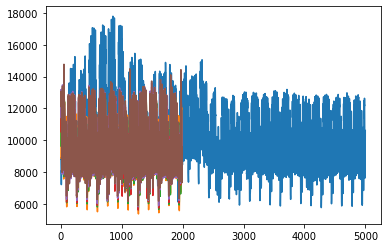

In [8]:
plt.plot(carga)
plt.plot(previsoes)


import plotly.graph_objects as go

# Criar figura
fig = go.Figure()

# Adicionar linha dos dados reais
fig.add_trace(go.Scatter(
    y=Y_test_real.flatten(),
    mode='lines',
    name='Dados Reais',
    line=dict(color='blue')
))

# Adicionar linha das previsões
fig.add_trace(go.Scatter(
    y=previsoes.flatten(),
    mode='lines',
    name='Previsão',
    line=dict(color='red', dash='dash')
))

# Configurar layout do gráfico
fig.update_layout(
    title='Previsão de Carga usando LSTM',
    xaxis_title='Tempo',
    yaxis_title='Carga',
    legend=dict(x=0, y=1),
    template='plotly_white',
)

# Mostrar gráfico interativo
fig.show()


In [83]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import streamlit as st

# Configurar o estilo do Streamlit
st.title("Previsão de Carga usando LSTM")

# Carregar os dados
st.write("### Carregando os dados...")
uploaded_file = st.file_uploader("Carregue o arquivo Excel com os dados:", type=["xlsx"])
if uploaded_file is not None:
    dados = pd.read_excel(uploaded_file)
    st.write("Visualização dos dados:")
    st.dataframe(dados.head())
    
    # Extraindo dados
    carga = dados.iloc[:20000, 3].values  # Coluna 4 (índice 3)
    
    # Normalizar os dados
    scaler = StandardScaler()
    carga_normalizada = scaler.fit_transform(carga.reshape(-1, 1)).flatten()
    
    # Criar dados em formato de série temporal
    def criar_dados(series, passos=50):
        X, Y = [], []
        for i in range(len(series) - passos):
            X.append(series[i:i + passos])
            Y.append(series[i + passos])
        return np.array(X), np.array(Y)

    # Preparar os dados
    passos_anteriores = 75
    X, Y = criar_dados(carga_normalizada, passos_anteriores)

    # Dividir os dados em treino e teste
    split = int(0.6 * len(X))
    X_train, Y_train = X[:split], Y[:split]
    X_test, Y_test = X[split:], Y[split:]

    # Ajustar o formato para LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Criar o modelo LSTM
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(75, activation='tanh', input_shape=(passos_anteriores, 1)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    st.write("Treinando o modelo...")
    # Treinar o modelo
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_test, Y_test),
        epochs=75,
        batch_size=132,
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Fazer previsões
    previsoes = model.predict(X_test)
    previsoes = scaler.inverse_transform(previsoes)
    Y_test_real = scaler.inverse_transform(Y_test.reshape(-1, 1))

    # Avaliar o modelo
    MAPE = np.mean(np.abs((previsoes - Y_test_real) / Y_test_real)) * 100
    MAE = np.mean(np.abs(previsoes - Y_test_real))
    RMSE = np.sqrt(np.mean((previsoes - Y_test_real) ** 2))

    st.write(f"**Erro Percentual Absoluto Médio (MAPE):** {MAPE:.4f}%")
    st.write(f"**Erro Absoluto Médio (MAE):** {MAE:.4f}")
    st.write(f"**Raiz do Erro Quadrático Médio (RMSE):** {RMSE:.4f}")

    # Criar o gráfico interativo com Plotly
    st.write("### Visualização dos Resultados Interativa:")
    fig = go.Figure()

    # Adicionar dados reais
    fig.add_trace(go.Scatter(
        y=Y_test_real.flatten(),
        mode='lines',
        name='Dados Reais',
        line=dict(color='blue')
    ))

    # Adicionar previsões
    fig.add_trace(go.Scatter(
        y=previsoes.flatten(),
        mode='lines',
        name='Previsão',
        line=dict(color='red', dash='dash')
    ))

    # Configurar o layout
    fig.update_layout(
        title="Previsão de Carga usando LSTM",
        xaxis_title="Tempo",
        yaxis_title="Carga",
        legend=dict(x=0, y=1),
        template="plotly_white"
    )

    # Mostrar o gráfico no Streamlit
    st.plotly_chart(fig, use_container_width=True)
